# GBRDC LiPD version example workflow - python code

### Ariella Arzey and Hugo Fahey

*School of Earth, Atmospheric and Life Sciences, University of Wollongong, Wollongong, NSW 2522, Australia*

This notebook documents an example of how a user can process, subset, and visualise the database data where the data is formatted as Linked Paleo Data (LiPD). This workflow produces two types of figures, line plots for visualising the record data and maps for visualising locations, as well as an overview on using the LiPD format. Data is filtered by sampling resolution, geochemical proxy, age, and region on the Great Barrier Reef.

This notebook also includes examples for;  
&nbsp;&nbsp;&nbsp; - Loading information from LiPD format into pandas.DataFrame (as is used in the accompanying Python_GBRCD_CSV_example_code.ipynb)\
&nbsp;&nbsp;&nbsp; - Importing data into, overviewing, and exploreing the dataset through use the Pyleoclim package

### Libraries

In [1]:
import re
import requests
import os
import zipfile
import lipd
from pylipd.lipd import LiPD
import pickle
import numpy as np
import math
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#### Load LiPD files
The files can be found at https://lipdverse.org/GBRCD/current_version/ \
v1_0_0 is the current version as of Feb. 2024 - later it may be necessary to update the numbers below to match the most recent file version

In [2]:
# functions for downloading and unzipping a file from a url
# Download a file from a url to a given file path
def download_file(url, destination_path):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(destination_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    file.write(chunk)
        print(f"File downloaded successfully to {destination_path}")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")
        
# unzip a .zip file in a given file path to a given file path
def unzip_file(zip_file_path, extraction_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extraction_path)
    print(f"File successfully extracted to {extraction_path}")

In [3]:
# Obtain the LiPD files - only necessary if you would like a local copy of the data
download_url = "https://lipdverse.org/GBRCD/current_version/GBRCD1_0_0.zip"
download_destination = "../GBRCD LiPD version/"
download_filename = os.path.basename(download_url)

# create the destination directory if it doesn't already exist
if not os.path.exists(download_destination):
    # If not, create it;
    os.makedirs(download_destination)
    print(f"Directory '{download_destination}' created.")
    
    # Download the zip
    download_file(download_url, os.path.join(download_destination, download_filename))

    # unzip the file
    unzip_file(os.path.join(download_destination, download_filename), download_destination)

else:
    # to avoid overwriting files by running this cell multiple times
    print(f"Directory '{download_destination}' already exists.")

Directory '../GBRCD LiPD version/' already exists.


In python, the data can either be loaded directly from LiPDverse, or locally from the lipd files or a pickle file.
Each of these methods are outlined in the following three cells, only one method of loading the data needs to be executed.

In [4]:
# Load from the downloaded LiPD files (method 1)
LiPD_files_path = [file for file in os.listdir('../GBRCD LiPD version/') if file.endswith('.lpd')]
GBRCD = LiPD()
GBRCD.load(LiPD_files_path)

# A single/selection of lipd file(s) can also be loaded by specifing the given file(s)
# e.g. LiPD_files_path = [('../GBRCD LiPD version/AL03DAV01_1.lpd')]

In [5]:
### Or; (method 2)
## the files can be read straight from LiPDverse.org
GBRCD = LiPD()
GBRCD.load(download_url)

In [6]:
### Or; (method 3)
# the files can be loaded from a pickle file (the pickle will be quicker to load)
# obtain the .pkl from LiPDverse
download_url_pkl = "https://lipdverse.org/GBRCD/current_version/GBRCD1_0_0.pkl"
download_filename_pkl = os.path.basename(download_url_pkl)
# download the file, if it isn't already downloaded
if not os.path.exists(os.path.join(download_destination, download_filename_pkl)):
    download_file(download_url_pkl, os.path.join(download_destination, download_filename_pkl))

# read the data from the .pkl 
pkl_to_open = open(os.path.join(download_destination, download_filename_pkl),'rb')
GBRCD = pickle.load(pkl_to_open)['D']
pkl_to_open.close()

##### Convert the multi-LiPD object (read from the files) into a LiPD time series object (TS) for manipulation and filtering
Again only one of the two following cells needs to be ran, depending on which method was used above to load the lipd files

In [7]:
# Following method 1 and 2, using pylipd.lipd package
GBRCD_TS = GBRCD.get_timeseries(GBRCD.get_all_dataset_names())

In [8]:
### Or;
# Following method 3, using lipd package
GBRCD_TS = lipd.extractTs(GBRCD)

extracting paleoData...
extracting: LO11NMI01
extracting: AL03PAN01_3
extracting: LO11PAN01
extracting: WU21CUR01
extracting: SA16HER05a
extracting: MC17DAV02
extracting: LO11BRO01
extracting: RE19EEL01
extracting: DR95LMI01
extracting: DE14ARL01
extracting: FA03DAV02
extracting: SA21RAT01
extracting: AL03PAN01_2
extracting: LO14NEL08
extracting: SA16HER05b
extracting: MC17DAV01
extracting: LO11CID01
extracting: DE14ARL02
extracting: DR99ABR02
extracting: AL03PAN01_1
extracting: FA03DAV01
extracting: IS98PAN01
extracting: RO14SQR01
extracting: ER16MAG01
extracting: LO11SMI01
extracting: LE12HAS01
extracting: RE19CLK01
extracting: JU08KES01a
extracting: SA16HER04b
extracting: AL03PAN01_4
extracting: ER20PAN02
extracting: LE12HKI01
extracting: RO14GKI01
extracting: RO14SQR02
extracting: MA00SLY01
extracting: LO11NOR01
extracting: PE05FLI01
extracting: JU08KES01b
extracting: SA16HER04a
extracting: CA07FLI01
extracting: ER20PAN01
extracting: RO14GKI02
extracting: LO11DUN01
extracting: FA03

#### Exploring the metadata and the format

In [9]:
## NOTE: GBRCD_TS is a list of dictionaries (not all entries have all the same keys)

# Creating a new list indexed by site name for ease of referencing data
GBRCD_TS_named = {entry['dataSetName']: entry for entry in GBRCD_TS}

# to list the keys for an entry (in this case the site AL03DAV01_1)
print(GBRCD_TS_named['AL03DAV01_1'].keys())

dict_keys(['mode', 'time_id', 'dataSetName', 'collectionYear', 'minYear', 'maxYear', 'notes', 'gbrIsSstCalibration', 'gbrUseSstCalibration', 'gbrHasAlternateCalibration', 'gbrIsCompositeCalibration', 'gbrIsCoreIDOtherStudy', 'datasetId', 'archiveType', 'createdBy', 'datasetVersion', 'changelog', 'lipdverseLink', 'pub1_author', 'pub1_firstAuthor', 'pub1_year', 'pub1_doi', 'pub1_citation', 'pub1_title', 'pub1_journal', 'pub2_author', 'pub2_firstAuthor', 'pub2_year', 'pub2_doi', 'pub2_citation', 'pub2_title', 'pub2_journal', 'geo_meanLon', 'geo_meanLat', 'geo_meanElev', 'geo_siteName', 'geo_notes', '@context', 'lipdVersion', 'tableType', 'paleoData_tableName', 'paleoData_filename', 'paleoData_missingValue', 'year', 'yearUnits', 'Distance', 'paleoData_core', 'paleoData_sensorSpecies', 'paleoData_gbrIsDatabaseDuplicate', 'paleoData_gbrDataCoverageGroup', 'paleoData_notes', 'paleoData_samplingResolution', 'paleoData_gbrIsAnomaly', 'paleoData_gbrChronologyNotes', 'paleoData_coralExtensionRate

In [10]:
# Access a dictionary by a given site name and key in the new list 
dataset_name_to_lookup = 'AL03DAV01_1' #change this as per lookup
key_to_lookup = 'minYear' #change this as per lookup
desired_dictionary = GBRCD_TS_named.get(dataset_name_to_lookup)
# Print the result
print(dataset_name_to_lookup,'->', key_to_lookup+":")
print(desired_dictionary[key_to_lookup])

AL03DAV01_1 -> minYear:
1989.4973


### Filter dataset by proxies, resolution, year, etc.

Here Ba/Ca is used as an example variable to filter the GBRCD

Some other important keys for filtering:\
• Record coverage (this is number of years of data and accounts for gaps):\
&nbsp;&nbsp;&nbsp; – paleoData_gbrDataCoverageGroup (1 = >100 years, 2 = 10-100 years & 3 = <10 years of data)\
• Temporal Coverage (this is the total temporal span of records):\
&nbsp;&nbsp;&nbsp; – minYear (record start year)\
&nbsp;&nbsp;&nbsp; – maxYear (record end year)\
• Record Resolution:\
&nbsp;&nbsp;&nbsp; – paleoData_samplingResolution (nominal resolution)\
• Location:\
&nbsp;&nbsp;&nbsp; – geo_latitude (record latitude; degrees N (all GBR latitudes are negative))\
&nbsp;&nbsp;&nbsp; – geo_longitude (record longitude; degrees E (all GBR longitudes are positive))\
&nbsp;&nbsp;&nbsp; – geo_siteName (name of the site/reef)\
• Species:\
&nbsp;&nbsp;&nbsp; – paleoData_sensorSpecies (coral genus and species (if known))\
• Record Method:\
&nbsp;&nbsp;&nbsp; – paleoData_measurementMethod (method used for record measurement)\
• SST Calibration:\
&nbsp;&nbsp;&nbsp; – gbrIsSstCalibration (record is SST calibration dataset (SrCa, UCa, d18O); T/F)\
&nbsp;&nbsp;&nbsp; – gbrUseSstCalibration (record uses SST calibration (SrCa, UCa, d18O); T/F)\
(All metadata fields may be be used for filtering, but the above list above includes the suggested starting point for investigating the data.)

In [11]:
# Filter for proxy of choice, e.g. Ba/Ca
proxy_ts = lipd.filterTs(GBRCD_TS,  'paleoData_variableName == BaCa')
# Filter for temporal resolution, e.g. bimonthly
proxy_ts = lipd.filterTs(proxy_ts,  'paleoData_samplingResolution >= 6')
# Filter for age range, e.g. since the year 1500
proxy_ts = lipd.filterTs(proxy_ts,  'minYear >= 1500')

# Calculate the number of records filtered for
n_proxies = len(proxy_ts)
print('Number of records:',n_proxies)

Found 78 matches from 1407 columns
Found 72 matches from 78 columns
Number of records: 72


#### Extract the information for use in plotting and mapping

In [12]:
# List all the sites that have been selected for in the filter
# Again for ease of reference making a copy of the filtered list with site name as the key
proxy_ts_named = {entry['dataSetName']: entry for entry in proxy_ts}

# Print the IDs
proxy_list = list(proxy_ts_named.keys())
proxy_list = ', '.join(proxy_list)
print(proxy_list)

AL03PAN01_3, MC17DAV02, FA03DAV02, SA21RAT01, AL03PAN01_2, MC17DAV01, FA03DAV01, LE12HAS01, AL03PAN01_4, LE12HKI01, FA03MYR01, LE19SUD01, LE18HAV02, LE05MAG01, AR24DIP01, LE18HAV01, WA13HAV01, LE12SHW01, SA21GFB01, FA03PAN01, RA17MYR02, DO22MAG01, DO22HMP01, WE09ARL01_1, MC03HAV01, LE12SHW02, SA21GKI01, RA17MYR01, WE09ARL01_2, FA03ORP01, LE18GFB02, FA03WHE01, LE19RUS01, WA13MYR01, LE18GFB01, LE19RUS02, AL03DAV01_2, LE12REP03, JU08RTI02, DO22FIT02, LE18PEL02, LE12REP02, DO22OYS01, DO22FIT01, LE12COB01, LE18PEL01, LE12REP01, LE12CID01, LE12WHI01, DO22PAN02, LE18NEL01, LE18PAN01, DO22ARL01, DO22BRT01, FA00PAN01, LE12CID02, AR24OTI02, DO22PAN01, LE18NEL02, LE12NMI01, AR24OTI03, LE12CID03, LE18PAN02, JU08KES03, LE19HIG01, FA03HAV01, DO22HIG01, EL19OTI01, LE07MAG01, MC03PAN01, JU08SCA03, DO18RIB01


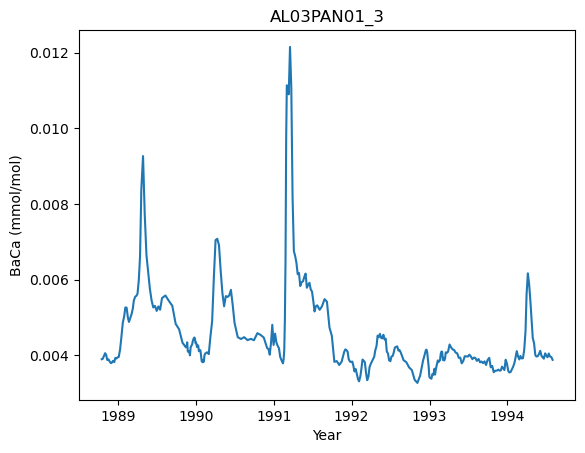

In [13]:
#To plot any individual proxy record for a given site

index_chosen = 'AL03PAN01_3' #change for any given site
proxy_data   = np.array(proxy_ts_named[index_chosen]['paleoData_values']).astype(float)
proxy_ages   = np.array(proxy_ts_named[index_chosen]['year']).astype(float)
dataset_name = proxy_ts_named[index_chosen]['dataSetName']

# Make a plot
plt.plot(proxy_ages,proxy_data)
plt.xlabel('Year')
plt.ylabel(str(proxy_ts_named[index_chosen]['paleoData_variableName'])+' (mmol/mol)')
plt.title(dataset_name)
plt.show()

In [14]:
# Extract proxy values, years, lasts and lons from the lipd time series

# iterate through the lipd list and access the desired field for each dictionary
# extract the filtered proxy values
proxies_all = []
for item in proxy_ts:
    if 'paleoData_values' in item:
        proxies_all.extend(np.array(item['paleoData_values']).astype(float))
        
# extract the filtered years
years_all = []
for item in proxy_ts:
    if 'year' in item:
        years_all.extend(np.array(item['year']).astype(float))

# labels according to site
labels_all = []
for item in proxy_ts:
    if 'dataSetName' in item:
        count = len(item['paleoData_values']) #to get the number of data entries for each site within the loop
        labels_all.extend([item['dataSetName']] * count) #repeat the label for the number of data entries

# lat and lons of all the proxy records
#create empty arrays of correct size
lats_all = np.zeros((n_proxies)); lats_all[:] = np.nan
lons_all = np.zeros((n_proxies)); lons_all[:] = np.nan
# Loop through all proxy records, storing the coresponding data in the newly-created arrays
for i in range(n_proxies):
    lats_all[i] = proxy_ts[i]['geo_meanLat']
    lons_all[i] = proxy_ts[i]['geo_meanLon']

#### Plotting all ‘modern’ bimonthly or higher resolution Ba/Ca data (entire GBR)
For ease of viewing, the y-axis, Ba/Ca values have been filtered to all values <0.1

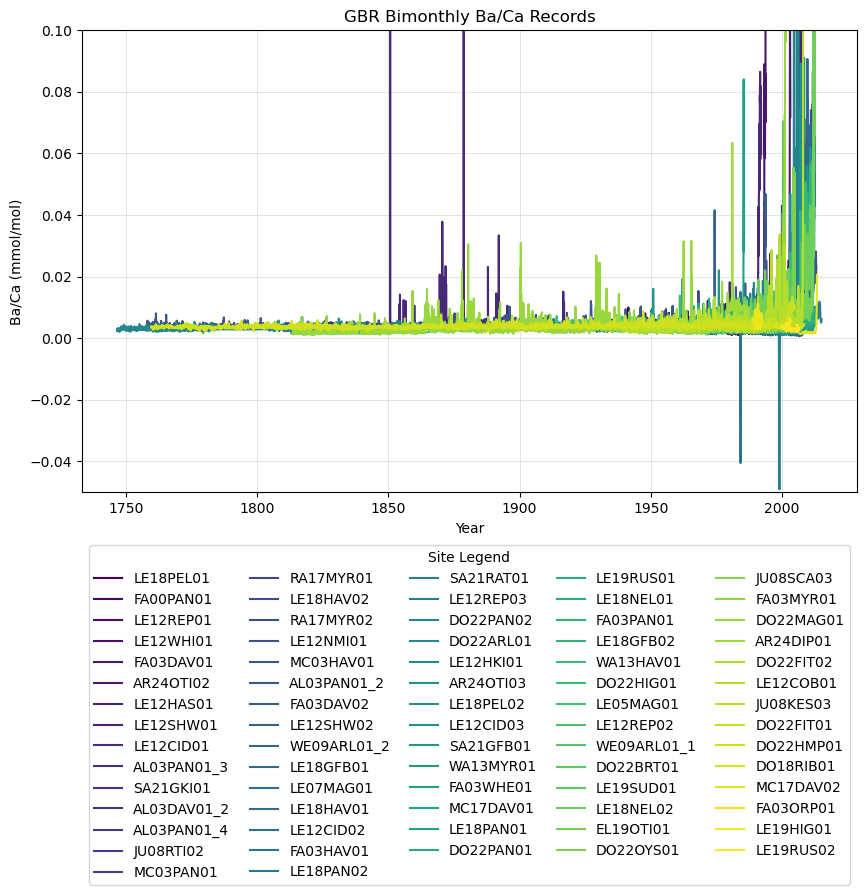

In [15]:
# Plot the data 
plt.figure(figsize=(10, 6))
unique_labels = set(labels_all) # asigning the site labels 
colours = plt.cm.viridis(np.linspace(0, 1, len(unique_labels))) #apply the viridis colour map (change cm to preference) 

# plot the corresponding proxy values to year values
for label, colour in zip(unique_labels, colours):
    indices = [i for i, value in enumerate(labels_all) if value == label]
    plt.plot(np.array(years_all)[indices], np.array(proxies_all)[indices], label=label, color=colour)

# Set a limit of 0.1 for the y-axis data, and min at nearest hundredth to the minimun of the data
y_min = math.floor(min(proxies_all)*100)/100
y_max = 0.1
plt.ylim(y_min, y_max)

# Labels
plt.xlabel('Year')
plt.ylabel('Ba/Ca (mmol/mol)')
plt.title('GBR Bimonthly Ba/Ca Records')
plt.grid(True, linewidth=0.5, alpha=0.5)

# Legend
total_legend_items = len(unique_labels) # Calculate the number of columns in the legend from number of items in plot
max_columns = 5
num_rows = (total_legend_items + max_columns - 1) // max_columns
num_columns = min(total_legend_items, max_columns)
plt.legend(title='Site Legend', fontsize=10, bbox_to_anchor=(0, -0.1, 1, 0), loc='upper left', mode='expand', ncol=num_columns)

plt.show()

#### Individually display each Ba/Ca record located south of latitude -22.5° on separate vertically stacked subplots sharing the x axis

In [16]:
# Filtering - as was done above but additionally with a spacial filter

# Filter for southern GBR sites (south of -22.5°)
proxy_ts_south = lipd.filterTs(proxy_ts,  'geo_meanLat < -22.5')
# Filter for age range, e.g. since the year 1500
proxy_ts_south = lipd.filterTs(proxy_ts_south,  'minYear >= 1950')

# Calculate the number of records filtered for
n_proxies_2 = len(proxy_ts_south)
print('Number of records:',n_proxies_2)

Found 6 matches from 72 columns
Found 5 matches from 6 columns
Number of records: 5


In [17]:
# extract the filtered proxy data
proxies_south = []
for item in proxy_ts_south:
    if 'paleoData_values' in item:
        proxies_south.extend(np.array(item['paleoData_values']).astype(float))
proxies_south = np.array(proxies_south)
        
# extract the filtered years
years_south = []
for item in proxy_ts_south:
    if 'year' in item:
        years_south.extend(np.array(item['year']).astype(float))
years_south = np.array(years_south)

# labels according to site
labels_south = []
for item in proxy_ts_south:
    if 'dataSetName' in item:
        count = len(item['paleoData_values']) #to get the number of data entries for each site within the loop
        labels_south.extend([item['dataSetName']] * count) #repeat the label for the number of data entries
labels_south = np.array(labels_south)

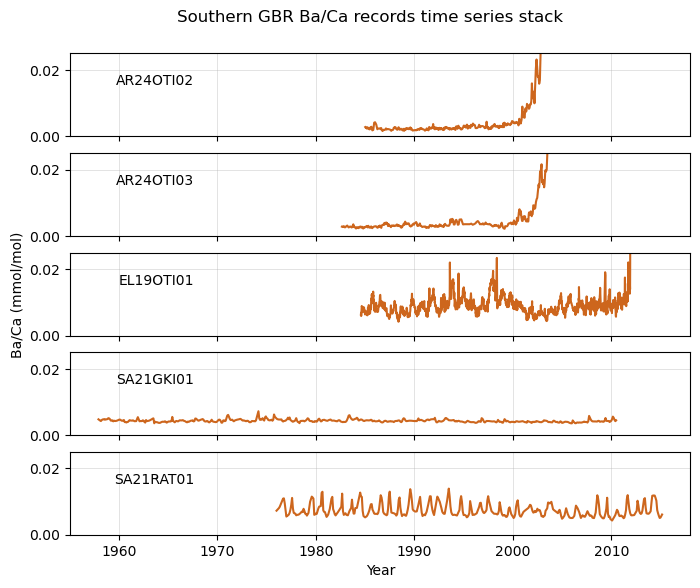

In [18]:
# Create subplots, one for each unique site
unique_labels = np.unique(labels_south) # Get unique site labels
fig, axes = plt.subplots(len(unique_labels), 1, figsize=(8, 1.25 * len(unique_labels)), sharex=True)

# Iterate through unique labels and plot each record on a separate axis
for i, label in enumerate(unique_labels):
    indices = np.where(labels_south == label)[0]  # Extract the first element of the tuple
    axes[i].plot(years_south[indices], proxies_south[indices], label=label, color='#CD661D')

    # Labels
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')#no labels on each individual yaxis
    axes[i].grid(True, linewidth=0.5, alpha=0.5) # gridlines
    axes[i].set_title('')#no titles above each plot, instead in the following line add the text within the plot
    axes[i].text(0.2, 0.75, label, transform=axes[i].transAxes, horizontalalignment='right', verticalalignment='top')
    axes[i].set_ylim(0, 0.025) # Set y-axis limits

# add a single yaxis title on the third plot from the top and x only on the bottom   
middle_ax = axes[len(unique_labels) // 2]
middle_ax.set_ylabel('Ba/Ca (mmol/mol)')
axes[4].set_xlabel('Year')
fig.suptitle('Southern GBR Ba/Ca records time series stack', y=0.95)
plt.show()

#### Mapping the location of the records

In [19]:
# Define a function to map all the filtered for sites within given bounds
def proxy_map(map_bounds, map_title): #input; [lat min, lat max, lon min, lon max] for extent of the map, and the given title
    plt.figure(figsize=(10, 6))
    ax1 = plt.subplot2grid((1,1),(0,0),projection=ccrs.PlateCarree()); ax1.set_extent(map_bounds ,crs=ccrs.PlateCarree())
    ax1.scatter(lons_all, lats_all, 25, color='#CD661D', edgecolor='#570000', marker='o', zorder=3, transform=ccrs.PlateCarree())
    ax1.coastlines(zorder=2)
    ax1.add_feature(cfeature.LAND, color='lightgrey', zorder=1)
    ax1.gridlines(color='lightgrey', linestyle='--', draw_labels=True, zorder=1)
    ax1.set_title(map_title)    
    plt.show()

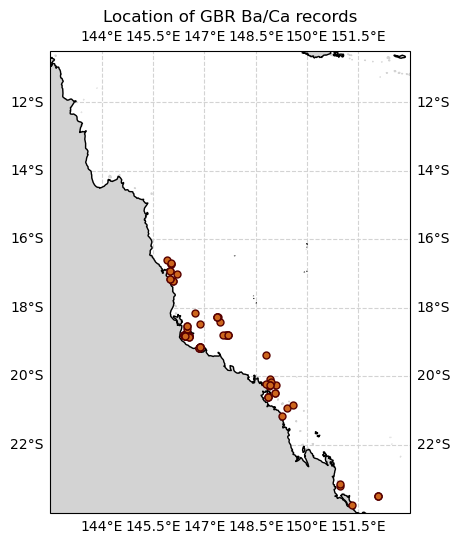

In [20]:
# Plot the locations of all proxy records in the region
map_title = 'Location of GBR Ba/Ca records'
lat_min = 142.5 # GBR bounds - replace with any given region (larger or smaller)
lat_max = 153
lon_min = -24
lon_max = -10.5

proxy_map([lat_min,lat_max,lon_min,lon_max], map_title)

#### Example of converting a collection of LiPD files to a pandas.DataFrame

In [21]:
import pandas as pd

In [22]:
# create an empty DataFrame
column_names=[  # keys from the lipds to extract into dataframe columns
    'dataSetName',
    'geo_siteName',
    'year',
    'paleoData_variableName',
    'paleoData_values',
    'geo_meanLat',
    'geo_meanLon',
    'paleoData_samplingResolution']
    
BaCa_DF = pd.DataFrame(index=range(len(proxy_ts)), columns=column_names)

In [23]:
# loop over the timeseries and read each column from given keys into the dataframe
i = 0                                                                                                                
for ts in proxy_ts:
    for name in column_names:                                                                                         
        try:
            BaCa_DF.loc[i, name] = ts[name]                                                                       
        except:
            BaCa_DF.loc[i, name] = np.nan                                                                           
    i += 1 
    
# drop any rows with all NaNs
BaCa_DF = BaCa_DF.dropna(how='all')

In [24]:
# display the metadata
BaCa_DF

,dataSetName,geo_siteName,year,paleoData_variableName,paleoData_values,geo_meanLat,geo_meanLon,paleoData_samplingResolution
0,AL03PAN01_3,Pandora Reef,"[1988.789617, 1988.803279, 1988.81694, 1988.83...",BaCa,"[0.003895129, 0.003905388, 0.003975346, 0.0040...",-18.8,146.4,weekly_uneven
1,MC17DAV02,Davies Reef,"[2006.738334, 2006.958334, 2007.208334, 2007.4...",BaCa,"[0.001596962, 0.001406254, 0.00141453, 0.00143...",-18.8,147.63,bimonthly_uneven
2,FA03DAV02,Davies Reef,"[1990.4101, 1990.4455, 1990.481, 1990.5165, 19...",BaCa,"[0.003729909, 0.003134373, 0.002950362, 0.0031...",-18.8,147.7,fortnightly_uneven
3,SA21RAT01,Rat Island,"[1976.001366, 1976.086066, 1976.165301, 1976.2...",BaCa,"[0.00724, 0.00751, 0.00777, 0.00804, 0.00845, ...",-23.7663,151.3178,monthly
4,AL03PAN01_2,Pandora Reef,"[1993.665753, 1993.679452, 1993.693151, 1993.7...",BaCa,"[0.003850507, 0.003844469, 0.004117438, 0.0041...",-18.8,146.4,weekly_uneven
...,...,...,...,...,...,...,...,...
67,EL19OTI01,One Tree Island,"[1984.57, 1984.59, 1984.6, 1984.62, 1984.64, 1...",BaCa,"[0.0063118605, 0.0068852469, 0.0058972972, 0.0...",-23.4872,152.0814,weekly_uneven
68,LE07MAG01,Magnetic Island,"[1813.0, 1815.0, 1817.0, 1819.0, 1821.0, 1823....",BaCa,"[0.0018524, 0.0016987, 0.0025266, 0.001812, 0....",-19.15,146.87,>annual
69,MC03PAN01,Pandora Reef,"[1965.0167, 1965.0347, 1965.0527, 1965.0708, 1...",BaCa,"[0.00473, 0.00452, 0.00438, 0.0046, 0.00424, 0...",-18.813,146.433,weekly_uneven
70,JU08SCA03,Scawfell Island,"[1952.096, 1952.115, 1952.135, 1952.154, 1952....",BaCa,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",-20.8522,149.6021,weekly


#### Example of exploring with Pyleoclim package

In [25]:
import pyleoclim as pyleo

##### Analysing a single site from lipd

In [26]:
# Setting up a GeoSeries object in Pyleoclim
# (here the copy of the lipd timeseries with site ID set to the list key, proxy_ts_named, is used to allow for easy selection)
index_chosen = 'AL03PAN01_3' #change for any given site within the filtered data

# give pyleoclim the relevant data (these properties need to be specific for pyleoclim)
metadata_dict={
    'label': proxy_ts_named[index_chosen]['dataSetName'],
    'time': proxy_ts_named[index_chosen]['year'],
    'time_unit': proxy_ts_named[index_chosen]['yearUnits'],
    'value_name': proxy_ts_named[index_chosen]['paleoData_variableName'],
    'value': proxy_ts_named[index_chosen]['paleoData_values'],
    'value_unit': proxy_ts_named[index_chosen]['paleoData_units'],
    'lat': proxy_ts_named[index_chosen]['geo_meanLat'],
    'lon': proxy_ts_named[index_chosen]['geo_meanLon'],
    'archiveType': proxy_ts_named[index_chosen]['archiveType']}
    
geoseries_selected = pyleo.GeoSeries(**metadata_dict)

Time axis values sorted in ascending order


Performing spectral analysis on individual series: 100%|█| 200/200 [00:04<00:00,


(<Figure size 1100x800 with 4 Axes>,
 {'ts': <Axes: xlabel='Time [years CE]', ylabel='BaCa [millimole/mole]'>,
  'dts': <Axes: xlabel='Counts'>,
  'map': {'map': <GeoAxes: xlabel='lon', ylabel='lat'>},
  'spec': <Axes: xlabel='Period [years CEs]', ylabel='PSD'>})

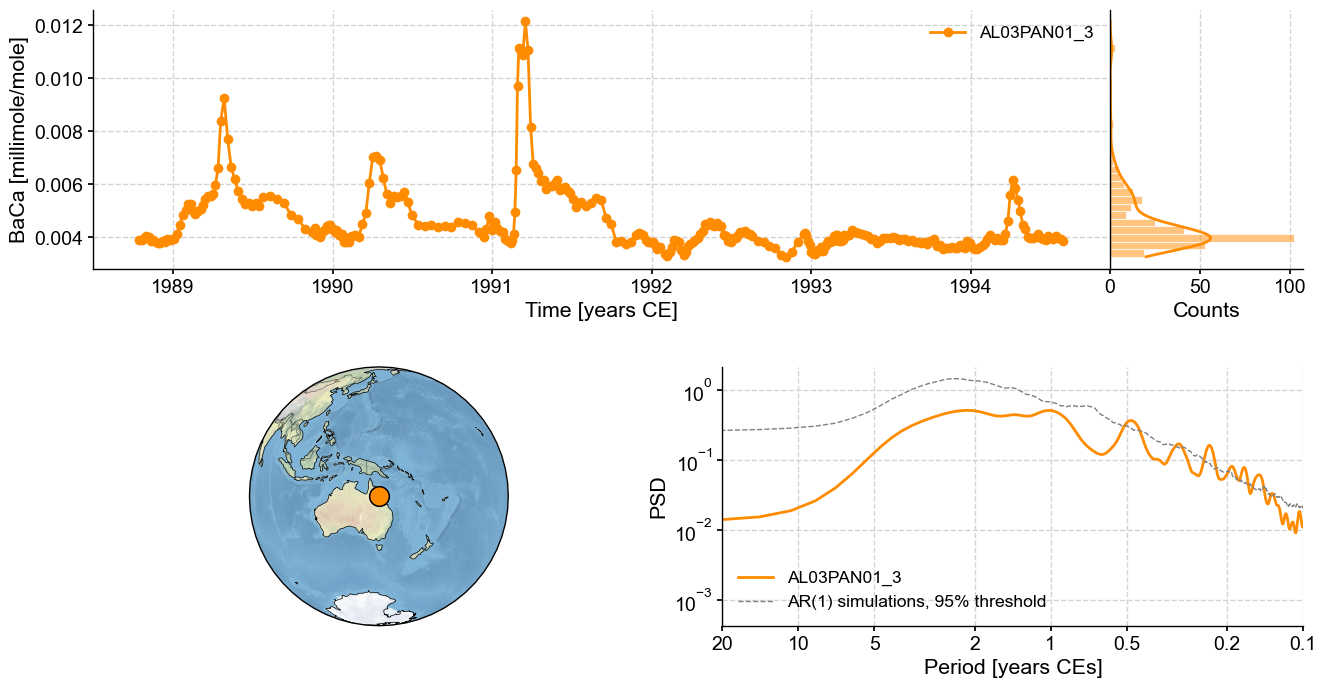

In [27]:
# to use pyleoclim's functionallity to present an overview of the site: 
# summarising the location of the record, plots the timeseries and runs spectral analysis to generate a periodogram
geoseries_selected.dashboard()

# also see;
# geoseries_selected.plot() # for the line plot individually
# geoseries_selected.map() # for the map individually

##### Analysing all filtered sites from lipd

In [28]:
# Setting up a MultipleGeoSeries object in Pyleoclim
# Iterate over the filtered lipd list to put the relevant information into the right place of a list of GeoSeries objects
geoseries_all_list = []
for item in proxy_ts:
    geoseries_all_list.append(pyleo.GeoSeries(
        label = item['dataSetName'],
        time = item['year'],
        time_unit = item['yearUnits'],
        value_name = item['paleoData_variableName'],
        value = item['paleoData_values'],
        value_unit = item['paleoData_units'],
        lat = item['geo_meanLat'],
        lon = item['geo_meanLon'],
        archiveType = item['archiveType']))

# Combine the list objects into a MultipleGeoSeries object
geoseries_all = pyleo.MultipleGeoSeries(geoseries_all_list)

# The other display functionallies also work the same way for MultipleGeoSeries objects, e.g.
# to map the location of all the filtered for records;
# geoseries_all.map()

Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
NaNs have been detected and dropped.
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values 

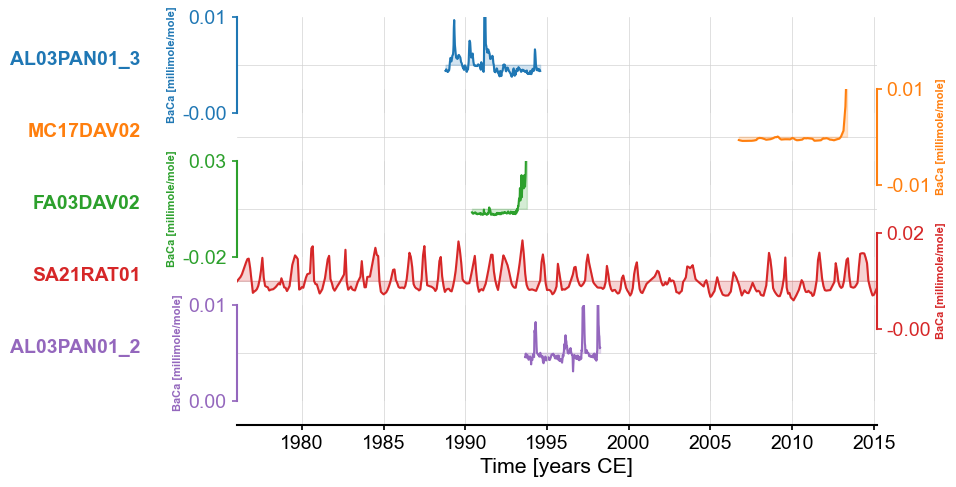

In [29]:
# Plot the filtered for records as a stack plot
# (the full plot is omitted here for legibility as there are 72 sites)
# geoseries_all.stackplot() # uncomment if desired

###
# To display a selection of the sites, here just the first five sites from the filtered data are used to instantiate a MultipleGeoSeries
geoseries_all_top5 = pyleo.MultipleSeries(geoseries_all_list[:5])

# Plotting the first five records in a stackplot
# geoseries_all_top5.stackplot() # uncomment if no edits required

###
# In this case as the default plot function only displays one decimal value on the y-axis, and this data requires at least two decimal places
# so the y-axis tick label format has to be adjusted using matplotlib's 
fig, ax = geoseries_all_top5.stackplot() # obtain the figure and axes when calling the pyleoclim stackplot function

# Defining a custom formatting function for y-axis ticks
def custom_yaxis_format(value, pos):
    return f'{value:.2f}'
from matplotlib.ticker import FuncFormatter

# loop through each axis (ax_idx) and set the custom y-axis tick label format
for idx, ax_idx in enumerate(ax):
    ax[ax_idx].yaxis.set_major_formatter(FuncFormatter(custom_yaxis_format))